# Descriptive analysis of Monant Medical Misinformation Dataset (REST API)

## Initialization

Import of necessary libraries

In [1]:
%matplotlib inline

import re
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import requests

REST API credentials

In [2]:
username = ''
password = ''

In order to make the analysis replicable, it uses a ”freeze time range” (currently set from January 1, 1990 to February 1, 2022). As the result, only those data that were present in the Monant platform up to this date are considered.

Note: Freeze time is set to the same date when the static dump was created, however, it may differ slightly in the exact time of day. Therefore small differences between descriptive analyses from REST API and static dump may appear. 

In [3]:
time_freeze_on = True
time_freeze_from = '1990-01-01'
time_freeze_to = '2022-02-01'

Set API base URL

In [4]:
API_URL = 'https://api.monant.kinit.sk/'

Set version of API

In [5]:
API_URL_v = 'v1/'

## Helper functions

### Get access token

In [6]:
def get_access_token():
    request_body = {'username': username, 'password': password}
    r = requests.post(API_URL + 'auth', json = request_body)
    access_token = r.json()['access_token']
    
    return(access_token)

Obtain a Monant API access token with a lifespan of several hours. Subsequently, a new one must be requested.

In [7]:
access_token = get_access_token()

### Get data

In [8]:
api_batch_size = 100

In [9]:
def get_data(request_URL, request_params):
    if time_freeze_on:
        if request_URL in ['articles', 'fact-checking-articles', 'discussions', 'discussion-posts']:
            request_params['from'] = time_freeze_from
            request_params['to'] = time_freeze_to
            
        if request_URL in ['claims', 'sources', 'relation-annotations', 'entity-annotations']:
            request_params['created_from'] = time_freeze_from
            request_params['created_to'] = time_freeze_to
    
    return(requests.get(
            API_URL + API_URL_v + request_URL,
            params=request_params,
            headers={"Content-Type": "application/json", "Authorization": f"JWT {access_token}"}
        ))

In [10]:
def get_entity_df(entity, request_params):
    request_params['size'] = 1
    pages_n = (get_data(entity, request_params).json()['pagination']['pages'] // api_batch_size) + 1
    entity_key = entity_to_entity_key(entity)
    data_json = []
    request_params['size'] = api_batch_size
    
    for page in range(1, pages_n + 1):
        request_params['page'] = page
        data_json_batch = json.loads(json.dumps(get_data(entity, request_params).json()[entity_key]))
        data_json = data_json + data_json_batch

    df_batch = pd.json_normalize(data_json)
    return df_batch

In [11]:
def entity_to_entity_key(entity):
    entity_key = re.sub('-', '_', entity)
    return entity_key

## Data preprocessing

In [12]:
df_fact_checking_articles = get_entity_df('fact-checking-articles', dict())

df_fca_medical_bool = df_fact_checking_articles.category.apply(lambda x: 'medical' in x)
df_fact_checking_articles_medical = df_fact_checking_articles[df_fca_medical_bool]

In [13]:
df_sources = get_entity_df('sources', dict())

sources_id_en_medical = []

for source in df_sources.iterrows():
    if (get_data('articles', {'size': 1, 'monitoring_tags': ['medical', 'english'], 'sources': source[1]['id']}).json()['pagination']['total']) > 0:
        sources_id_en_medical.append(source[1]['id'])

sources_id_en_medical_reliable = df_sources.loc[(df_sources['id'].isin(sources_id_en_medical)) & (df_sources['veracity'] == 'reliable')].id
sources_id_en_medical_unknown = df_sources.loc[(df_sources['id'].isin(sources_id_en_medical)) & (df_sources['veracity'] == 'unknown')].id
sources_id_en_medical_unreliable = df_sources.loc[(df_sources['id'].isin(sources_id_en_medical)) & (df_sources['veracity'] == 'unreliable')].id

# Overview of all Monant data

_Note: The Monant platform is used to collect not only English medical data (as contained in the provided dataset), but also medical data in additional low-resource languages (at the moment Slovak, Czech) and from additional domains (e.g., politics). These additional data are available via REST API interface._

_In this part of descriptive analyses, we provide overview of additional data collected by the Monant platform, also beyond the scope of the presented medical English misinformation dataset._

Monant have collected so far in total:

In [14]:
for entity in ['articles', 'sources', 'fact-checking-articles', 'claims', 'discussion-posts', 'discussions']:
    print('Number of ' + str(entity) + ': ' + str(get_data(entity, {'size': 1}).json()['pagination']['total']))
    
    if entity in ['sources']:
        print('Average number of articles per source: ' + str(round(get_data('articles', {'size': 1}).json()['pagination']['total'] / get_data(entity, {'size': 1}).json()['pagination']['total'], 2)))

Number of articles: 885403
Number of sources: 256
Average number of articles per source: 3458.61
Number of fact-checking-articles: 8733
Number of claims: 9756
Number of discussion-posts: 778947
Number of discussions: 47849


In [15]:
for reliability in ['reliable', 'unreliable', 'unknown']:
    print('Number of ' + str(reliability) + ' sources: ' + str(get_data('sources', {'size': 1, 'veracity': reliability}).json()['pagination']['total']))

Number of reliable sources: 22
Number of unreliable sources: 66
Number of unknown sources: 168


In [16]:
print('Number of fact checking articles sources: ' + str(len(df_fact_checking_articles.groupby(['source_id']))))
print('\n')

for source in df_fact_checking_articles['source_id'].unique():    
    source_json = get_data('sources', {'ids': source}).json()['sources'][0]
    source_name = source_json.get('name', '')
    source_n_articles = len(df_fact_checking_articles[df_fact_checking_articles.source_id == source])
    
    print('Number of fact checking articles from source ' + str(source_name) + ': ' + str(source_n_articles))

Number of fact checking articles sources: 17


Number of fact checking articles from source factcheck.org: 2654
Number of fact checking articles from source snopes.com: 769
Number of fact checking articles from source fullfact.org: 3977
Number of fact checking articles from source metafact.io: 654
Number of fact checking articles from source politifact.com: 111
Number of fact checking articles from source healthfeedback.org: 435
Number of fact checking articles from source sciencefeedback.co: 76
Number of fact checking articles from source bbc.com: 1
Number of fact checking articles from source bbc.co.uk: 1
Number of fact checking articles from source cbsnews.com: 7
Number of fact checking articles from source washingtonpost.com: 34
Number of fact checking articles from source reporterslab.org: 5
Number of fact checking articles from source afp.com: 2
Number of fact checking articles from source polygraph.info: 1
Number of fact checking articles from source nytimes.com: 3
Number of fac

In [17]:
for entity in ['articles', 'discussion-posts']:
    print('Number of medical ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'monitoring_tags': 'medical'}).json()['pagination']['total']))

Number of medical articles: 355417
Number of medical discussion-posts: 760868


In [18]:
for language in ['english', 'slovak', 'czech']:
    print('Number of ' + str(language) + ' medical ' + str('articles') + ': ' + str(get_data('articles', {'size': 1, 'monitoring_tags': ['medical', language]}).json()['pagination']['total']))

Number of english medical articles: 316832
Number of slovak medical articles: 17815
Number of czech medical articles: 20770


# Descriptive Analysis of Raw Data

In the following descriptive analysis, we focus medical English data, which are contained in the provided dataset.

In [19]:
monitoring_tags = ['medical', 'english']

Dataset contains in total:

In [54]:
for entity in ['articles', 'sources', 'fact-checking-articles', 'claims', 'discussion-posts']:
    if entity in ['articles', 'discussion-posts', 'discussions']:
        print('Number of ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'monitoring_tags': monitoring_tags}).json()['pagination']['total']))
        
    if entity in ['claims']:
        print('Number of ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'category': ['medical']}).json()['pagination']['total']))

    if entity in ['fact-checking-articles']:
        print('Number of ' + str(entity) + ': ' + str(len(df_fact_checking_articles_medical)))

    if entity in ['sources']:
        print('Number of ' + str(entity) + ': ' + str(len(sources_id_en_medical) + len(df_fact_checking_articles_medical['source_id'].unique())))
        print('Average number of articles per source: ' + str(round(get_data('articles', {'size': 1, 'monitoring_tags': monitoring_tags}).json()['pagination']['total'] / (len(sources_id_en_medical) + len(df_fact_checking_articles_medical['source_id'].unique())), 2)))

Number of articles: 316832
Number of sources: 215
Average number of articles per source: 1473.64
Number of fact-checking-articles: 2654
Number of claims: 3423
Number of discussion-posts: 710993


### Sources

In [21]:
print('Number of medical articles\' sources: ' + str(len(sources_id_en_medical)))
print('Number of medical fact checking articles\' sources: ' + str(len(df_fact_checking_articles_medical['source_id'].unique())))

Number of medical articles' sources: 208
Number of medical fact checking articles' sources: 7


In [22]:
for reliability in ['reliable', 'unreliable', 'unknown']:
    print('Number of articles\' ' + str(reliability) + ' sources: ' + str(get_data('sources', {'size': 1, 'veracity': reliability, 'ids': sources_id_en_medical}).json()['pagination']['total']))

Number of articles' reliable sources: 22
Number of articles' unreliable sources: 48
Number of articles' unknown sources: 138


### Articles

In [23]:
articles_en_med_total = get_data('articles', {'size': 1, 'monitoring_tags': monitoring_tags}).json()['pagination']['total']

for reliability,sources_id_en_medical_reliability in zip(['reliable', 'unknown', 'unreliable'], [sources_id_en_medical_reliable, sources_id_en_medical_unknown, sources_id_en_medical_unreliable]):
    sources_articles_n = 0
    for source_id in sources_id_en_medical_reliability:
        source_articles_n = get_data('articles', {'size': 1, 'sources': source_id}).json()['pagination']['total']
        sources_articles_n = sources_articles_n + source_articles_n
        
    print('Number of articles from ' + str(reliability) + ' sources: ' + str(sources_articles_n))
    print('Percentage of articles from ' + str(reliability) + ' sources: ' + str(round(sources_articles_n*100/articles_en_med_total, 2)) + ' %')

Number of articles from reliable sources: 123227
Percentage of articles from reliable sources: 38.89 %
Number of articles from unknown sources: 16408
Percentage of articles from unknown sources: 5.18 %
Number of articles from unreliable sources: 177197
Percentage of articles from unreliable sources: 55.93 %


In [24]:
day_start = '-01-01'
day_end = '-12-31'
year_start = 1995
year_end = int(time_freeze_to.split('-')[0])
request_URL = 'articles'

years = []
n_articles_year = []

for year in range(year_start, year_end + 1, 1):
    date_start = str(year) + day_start
    if year == year_end:
        date_end = time_freeze_to
    else:
        date_end = str(year) + day_end
    
    years.append(year)
    n_articles_year.append(get_data('articles', {'size': 1, 'monitoring_tags': monitoring_tags, 'published_at_from': date_start, 'published_at_to': date_end}).json()['pagination']['total'])

Number of English medical articles published in years 1995-(freeze time year):


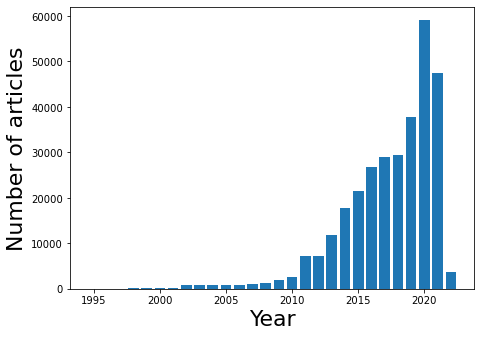

In [25]:
print('Number of English medical articles published in years 1995-(freeze time year):')
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

font = {'size': 17} 
f = plt.figure()
plt.xlabel('Year', fontsize=22)
plt.ylabel('Number of articles', fontsize=22)
matplotlib.rc('font', **font)
plt.bar(years, n_articles_year)

f.savefig("image_export/articles_timeline.pdf", bbox_inches='tight')

### Fact-checking articles & Claims

In [26]:
for source in df_fact_checking_articles_medical['source_id'].unique():    
    source_json = get_data('sources', {'ids': source}).json()['sources'][0]
    source_name = source_json.get('name', '')
    source_veracity = source_json.get('veracity')
    source_n_articles = len(df_fact_checking_articles_medical[df_fact_checking_articles_medical.source_id == source])
    
    print('Number of fact checking articles from source ' + str(source_name) + ': ' + str(source_n_articles))

Number of fact checking articles from source snopes.com: 768
Number of fact checking articles from source fullfact.org: 967
Number of fact checking articles from source metafact.io: 450
Number of fact checking articles from source factcheck.org: 30
Number of fact checking articles from source healthfeedback.org: 435
Number of fact checking articles from source sciencefeedback.co: 3
Number of fact checking articles from source politifact.com: 1


In [27]:
ratings = []
n_claims_ratings = []
ratings_names_dict = {
    'null': 'Unknown',
    'unknown': 'Unknown',
    'false': 'False',
    'mostly-false': 'Mostly\nfalse',
    'mixture': 'Mixture',
    'mostly-true': 'Mostly\ntrue',
    'true': 'True'
}

print('Number of claims: ' + str(get_data('claims', {'size': 1, 'category': ['medical']}).json()['pagination']['total']))
print('\n')

claims_medical_n = get_data('claims', {'size': 100, 'category': ['medical']}).json()['pagination']['total']
claims_medical_n_rating_unknown = claims_medical_n
for rating in ['false', 'mostly-false', 'mixture', 'mostly-true', 'true']:
    claims_medical_n_rating = get_data('claims', {'size': 1, 'category': ['medical'], 'rating': rating}).json()['pagination']['total']
    print('Number of ' + str(rating) + ' claims: ' + str(claims_medical_n_rating))
    print(f"Percentage of {str(rating)} claims: {round((claims_medical_n_rating / claims_medical_n * 100), 2)} %\n")
    claims_medical_n_rating_unknown = claims_medical_n_rating_unknown - claims_medical_n_rating
    
    ratings.append(ratings_names_dict[rating])
    n_claims_ratings.append(claims_medical_n_rating)
    
    
rating = 'unknown'
print('Number of ' + str(rating) + ' claims: ' + str(claims_medical_n_rating_unknown))
print(f"Percentage of {str(rating)} claims: {round((claims_medical_n_rating_unknown / claims_medical_n * 100), 2)} %\n")
ratings.append(rating)
n_claims_ratings.append(claims_medical_n_rating_unknown)

Number of claims: 3423


Number of false claims: 983
Percentage of false claims: 28.72 %

Number of mostly-false claims: 60
Percentage of mostly-false claims: 1.75 %

Number of mixture claims: 100
Percentage of mixture claims: 2.92 %

Number of mostly-true claims: 39
Percentage of mostly-true claims: 1.14 %

Number of true claims: 261
Percentage of true claims: 7.62 %

Number of unknown claims: 1980
Percentage of unknown claims: 57.84 %



Number of medical claims in our dataset per claim rating:


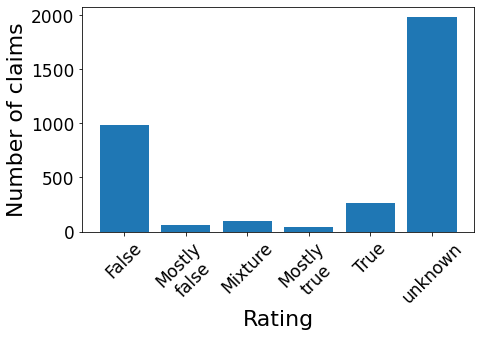

In [28]:
print('Number of medical claims in our dataset per claim rating:')
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

font = {'size': 17} 
f = plt.figure()
plt.xlabel('Rating', fontsize=22)
plt.ylabel('Number of claims', fontsize=22)
matplotlib.rc('font', **font)
plt.xticks(rotation=45)
plt.bar(ratings, n_claims_ratings)

f.savefig("image_export/claims_veracity.pdf", bbox_inches='tight')

# Descriptive Analysis of Manual Annotations

In [29]:
df_presence_annotations = get_entity_df('relation-annotations', {'annotation_type': 'Claim presence', 'annotation_category': 'label'})

In [30]:
total_count = len(df_presence_annotations[(df_presence_annotations['created_at'] < '2022-01-01') & ((df_presence_annotations['value.value'] == 'present') | (df_presence_annotations['value.value'] == 'suggestive') | (df_presence_annotations['value.value'] == 'not-present'))])

count = len(df_presence_annotations[(df_presence_annotations['created_at'] < '2022-01-01') & ((df_presence_annotations['value.value'] == 'present') | (df_presence_annotations['value.value'] == 'suggestive'))])
print('Number of presence labels with value present/suggestive for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_presence_annotations[(df_presence_annotations['created_at'] < '2022-01-01') & (df_presence_annotations['value.value'] == 'not-present')])
print('Number of presence labels with value not present for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of presence labels in total for Sample 1: ' + str(total_count))


total_count = len(df_presence_annotations[(df_presence_annotations['created_at'] > '2022-01-01') & ((df_presence_annotations['value.value'] == 'present') | (df_presence_annotations['value.value'] == 'suggestive') | (df_presence_annotations['value.value'] == 'not-present'))])

count = len(df_presence_annotations[(df_presence_annotations['created_at'] > '2022-01-01') & ((df_presence_annotations['value.value'] == 'present') | (df_presence_annotations['value.value'] == 'suggestive'))])
print('Number of presence labels with value present/suggestive for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_presence_annotations[(df_presence_annotations['created_at'] > '2022-01-01') & (df_presence_annotations['value.value'] == 'not-present')])
print('Number of presence labels with value not present for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of presence labels in total for Sample 2: ' + str(total_count))

total_count = len(df_presence_annotations[((df_presence_annotations['value.value'] == 'present') | (df_presence_annotations['value.value'] == 'suggestive') | (df_presence_annotations['value.value'] == 'not-present'))])

count = len(df_presence_annotations[((df_presence_annotations['value.value'] == 'present') | (df_presence_annotations['value.value'] == 'suggestive'))])
print('Number of presence labels with value present/suggestive for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_presence_annotations[(df_presence_annotations['value.value'] == 'not-present')])
print('Number of presence labels with value not present for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of presence labels in total for both samples: ' + str(total_count))

Number of presence labels with value present/suggestive for Sample 1: 222 (50.57 %)
Number of presence labels with value not present for Sample 1: 217 (49.43 %)
Number of presence labels in total for Sample 1: 439
Number of presence labels with value present/suggestive for Sample 2: 101 (75.37 %)
Number of presence labels with value not present for Sample 2: 33 (24.63 %)
Number of presence labels in total for Sample 2: 134
Number of presence labels with value present/suggestive for both samples: 323 (56.37 %)
Number of presence labels with value not present for both samples: 250 (43.63 %)
Number of presence labels in total for both samples: 573


In [51]:
disagreement_count = 0

for index,presence_annotation in df_presence_annotations.iterrows():
    annotation_values = set()
    for annotation in presence_annotation['value.annotations']:
        annotation_values.add(annotation['value'])

    if ('present' in annotation_values or 'suggestive' in annotation_values) and ('not-present' in annotation_values):
        disagreement_count = disagreement_count + 1
        
total_count = len(df_presence_annotations)
print('Number of presence labels in which annotators\' disagreement occured: ' + str(disagreement_count) + ' (' + str(round(disagreement_count*100/total_count, 2)) + ' %)')

Number of presence labels in which annotators' disagreement occured: 63 (8.57 %)


In [37]:
df_stance_annotations = get_entity_df('relation-annotations', {'annotation_type': 'Claim stance', 'annotation_category': 'label'})

In [38]:
total_count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & ((df_stance_annotations['value.value'] == 'supporting') | (df_stance_annotations['value.value'] == 'contradicting') | (df_stance_annotations['value.value'] == 'neutral'))])

count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & (df_stance_annotations['value.value'] == 'supporting')])
print('Number of stance labels with value promoting for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & (df_stance_annotations['value.value'] == 'contradicting')])
print('Number of stance labels with value contradicting for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] < '2022-01-01') & (df_stance_annotations['value.value'] == 'neutral')])
print('Number of stance labels with value neutral for Sample 1: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of stance labels in total for Sample 1: ' + str(total_count))


total_count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & ((df_stance_annotations['value.value'] == 'supporting') | (df_stance_annotations['value.value'] == 'contradicting') | (df_stance_annotations['value.value'] == 'neutral'))])

count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & (df_stance_annotations['value.value'] == 'supporting')])
print('Number of stance labels with value promoting for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & (df_stance_annotations['value.value'] == 'contradicting')])
print('Number of stance labels with value contradicting for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['created_at'] > '2022-01-01') & (df_stance_annotations['value.value'] == 'neutral')])
print('Number of stance labels with value neutral for Sample 2: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of stance labels in total for Sample 2: ' + str(total_count))

total_count = len(df_stance_annotations[((df_stance_annotations['value.value'] == 'supporting') | (df_stance_annotations['value.value'] == 'contradicting') | (df_stance_annotations['value.value'] == 'neutral'))])

count = len(df_stance_annotations[(df_stance_annotations['value.value'] == 'supporting')])
print('Number of stance labels with value promoting for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['value.value'] == 'contradicting')])
print('Number of stance labels with value contradicting for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
count = len(df_stance_annotations[(df_stance_annotations['value.value'] == 'neutral')])
print('Number of stance labels with value neutral for both samples: ' + str(count) + ' (' + str(round(count*100/total_count, 2)) + ' %)')
print('Number of stance labels in total for both samples: ' + str(total_count))

Number of stance labels with value promoting for Sample 1: 129 (61.43 %)
Number of stance labels with value contradicting for Sample 1: 62 (29.52 %)
Number of stance labels with value neutral for Sample 1: 19 (9.05 %)
Number of stance labels in total for Sample 1: 210
Number of stance labels with value promoting for Sample 2: 74 (74.75 %)
Number of stance labels with value contradicting for Sample 2: 24 (24.24 %)
Number of stance labels with value neutral for Sample 2: 1 (1.01 %)
Number of stance labels in total for Sample 2: 99
Number of stance labels with value promoting for both samples: 203 (65.7 %)
Number of stance labels with value contradicting for both samples: 86 (27.83 %)
Number of stance labels with value neutral for both samples: 20 (6.47 %)
Number of stance labels in total for both samples: 309


In [50]:
disagreement_count = 0

for index,stance_annotation in df_stance_annotations.iterrows():
    annotation_values = set()
    for annotation in stance_annotation['value.annotations']:
        annotation_values.add(annotation['value'])
        
    if 'supporting' in annotation_values and 'contradicting' in annotation_values or 'supporting' in annotation_values and 'neutral' in annotation_values or 'contradicting' in annotation_values and 'neutral' in annotation_values:
        disagreement_count = disagreement_count + 1
        
total_count = len(df_presence_annotations)
print('Number of stance labels in which annotators\' disagreement occured: ' + str(disagreement_count) + ' (' + str(round(disagreement_count*100/total_count, 2)) + ' %)')

Number of stance labels in which annotators' disagreement occured: 51 (6.94 %)


# Descriptive Analysis of Predicted Annotations

Besides raw data and manual labels, the introduced dataset also contains the predicted annotations (for claims presence, article stance and article-claim pair veracities).

In [41]:
df_entity_annotations = get_entity_df('entity-annotations', {'annotation_type': 'Article veracity', 'annotation_category': 'prediction'})

In [42]:
df_entity_annotations_vclaims = df_entity_annotations[df_entity_annotations['value.claims'].map(lambda d: len(d)) > 0]

In [55]:
sources_reliable_ids = df_sources[df_sources['veracity'] == 'reliable']['id'].tolist()
sources_unreliable_ids = df_sources[df_sources['veracity'] == 'unreliable']['id'].tolist()

articles_reliable_ids = list()
articles_unreliable_ids = list()

for source_id in sources_reliable_ids:
    article_ids = [0]
    while article_ids:
        article_ids = get_data('articles', {'id_only': 'yes', 'count': 1000, 'last_id': article_ids[-1], 'sources': source_id}).json()['ids']
        articles_reliable_ids.extend(article_ids)
    
for source_id in sources_unreliable_ids:
    article_ids = [0]
    while article_ids:
        article_ids = get_data('articles', {'id_only': 'yes', 'count': 1000, 'last_id': article_ids[-1], 'sources': source_id}).json()['ids']
        articles_unreliable_ids.extend(article_ids)

In [56]:
ac_pairs_present_yes = 0
ac_pairs_present_no = 0

claims_present_id = set()
claims_present_not_id = set()

veracity_set = {'false', 'mixture', 'mostly-false', 'mostly-true', 'true', 'unknown'}
claims_pveracity_n = dict()
for veracity in veracity_set:
    claims_pveracity_n[veracity] = 0
    
stance_set = {'contradicting', 'neutral', 'supporting'}
claims_stance_n = dict()
for stance in stance_set:
    claims_stance_n[stance] = 0
    
veracity_consistency_set = {'true', 'false', 'inconsistent'}
veracity_consistency_n = dict()
for veracity in veracity_consistency_set:
    veracity_consistency_n[veracity] = 0
    
veracity_binary_set = {' true', ' false', ''}
reliability_set = {'unreliable', 'reliable', 'unknown'}
veracity_reliability_n = dict()

for reliability in reliability_set:
    for veracity in veracity_binary_set:
        veracity_reliability_n[reliability + veracity] = 0


for index, row in df_entity_annotations_vclaims.iterrows():
    
    if int(row['entity_id']) in articles_reliable_ids:
        source_reliability = 'reliable' 
    elif int(row['entity_id']) in articles_unreliable_ids:
        source_reliability = 'unreliable'
    else:
        source_reliability = 'unknown'
    
    article_veracity_init = True
    veracity_consistent = True
    
    for claim in row['value.claims']:
        
        if claim['presence'] == 'yes':
            ac_pairs_present_yes = ac_pairs_present_yes + 1
            
            claims_present_id.add(claim['claim_id'])
            
            if claim['stance'] in claims_stance_n:
                claims_stance_n[claim['stance']] = claims_stance_n[claim['stance']] + 1
            else:
                claims_stance_n['neutral'] = claims_stance_n['neutral'] + 1
            
            claims_pveracity_n[claim['partial_veracity']] = claims_pveracity_n[claim['partial_veracity']] + 1
            veracity_reliability_n[source_reliability] = veracity_reliability_n[source_reliability] + 1
            
            if (claim['partial_veracity'] in {'false', 'mostly-false', 'mostly-true', 'true'}):
                if claim['partial_veracity'] in {'mostly-true', 'true'}:
                    claim_veracity = 'true'
                    veracity_reliability_n[source_reliability + ' ' + claim_veracity] = veracity_reliability_n[source_reliability +' '+ claim_veracity] + 1
                if claim['partial_veracity'] in {'false', 'mostly-false'}:
                    claim_veracity = 'false'
                    veracity_reliability_n[source_reliability + ' ' + claim_veracity] = veracity_reliability_n[source_reliability +' '+ claim_veracity] + 1
                    
                if article_veracity_init:
                    article_veracity = claim_veracity
                    article_veracity_init = False
                    
                if article_veracity != claim_veracity:
                    veracity_consistent = False

    if article_veracity_init == False:
            if veracity_consistent:
                veracity_consistency_n[article_veracity] = veracity_consistency_n[article_veracity] + 1
            else:
                veracity_consistency_n['inconsistent'] = veracity_consistency_n['inconsistent'] + 1

ac_pairs_present_all = get_data('relation-annotations', {'size': 1, 'annotation_type': 'Claim presence', 'annotation_category': 'prediction'}).json()['pagination']['total']
ac_pairs_present_no = ac_pairs_present_all - ac_pairs_present_yes

print('Number of not present article-claim mappings: ' + str(ac_pairs_present_no))
print('Number of present article-claim mappings: ' + str(ac_pairs_present_yes))

print('\n')

print('Number of mapped articles: ' + str(len(df_entity_annotations_vclaims)))
print(f"Percentage of mapped articles : {round((len(df_entity_annotations_vclaims) / get_data('articles', {'size': 1, 'monitoring_tags': ['medical', 'english']}).json()['pagination']['total'] * 100), 2)} %\n")

print('\n')

print('Number of mapped claims: ' + str(len(claims_present_id)))
print(f"Percentage of mapped claims: {round((len(claims_present_id) / get_data('claims', {'size': 1, 'category': ['medical']}).json()['pagination']['total'] * 100), 2)} %\n")

print('\n')

print('Number of present mapped claims with stance: ' + str(ac_pairs_present_yes))
for stance,number in claims_stance_n.items():
    print('Number of present mapped claims with ' + str(stance) + ' stance: ' + str(number))
    print(f"Percentage of present mapped claims with {str(stance)} stance: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
print('\n')

print('Number of present mapped claims with partial veracity: ' + str(ac_pairs_present_yes))                                                                              
for veracity,number in claims_pveracity_n.items():
    print('Number of present mapped claims with ' + str(veracity) + ' stance: ' + str(number))
    print(f"Percentage of present mapped claims with {str(veracity)} stance: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
    
print('\n')
                                                                            
for veracity,number in veracity_consistency_n.items():
    print('Number of mapped articles witch veracity consistancy status ' + str(veracity) + ': ' + str(number))
    print(f"Percentage of mapped articles witch veracity consistancy status {str(veracity)}: {round((number / len(df_entity_annotations_vclaims) * 100), 2)} %\n")
    
print('\n')
       
for rating,number in veracity_reliability_n.items():
    if rating in ['unreliable', 'reliable', 'unknown']:
        print('Number of present claim article pairs - ' + str(rating) + ' sources: ' + str(number))
        print(f"Percentage of present claim article pairs - {str(rating)} sources: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
    else:
        reliability = rating.split()[0]
        veracity = rating.split()[1]
        print('Number of present claim article pairs - ' + str(veracity) + ' veracity from ' + str(reliability) + ' source: ' + str(number))
        print(f"Percentage of present claim article pairs from {str(reliability)} sources - {str(veracity)} veracity from {str(reliability)} source: {round((number / veracity_reliability_n[reliability] * 100), 2)} %\n")

Number of not present article-claim mappings: 365528
Number of present article-claim mappings: 50953


Number of mapped articles: 34850
Percentage of mapped articles : 11.0 %



Number of mapped claims: 1193
Percentage of mapped claims: 34.85 %



Number of present mapped claims with stance: 50953
Number of present mapped claims with contradicting stance: 8720
Percentage of present mapped claims with contradicting stance: 17.11 %

Number of present mapped claims with neutral stance: 2065
Percentage of present mapped claims with neutral stance: 4.05 %

Number of present mapped claims with supporting stance: 40168
Percentage of present mapped claims with supporting stance: 78.83 %



Number of present mapped claims with partial veracity: 50953
Number of present mapped claims with mostly-true stance: 41
Percentage of present mapped claims with mostly-true stance: 0.08 %

Number of present mapped claims with true stance: 8831
Percentage of present mapped claims with true stance: 17.33 %

N

In [57]:
claims_source_names = dict()
claims_sources_names_set = set()

for claim_id in claims_present_id:
    fcas = get_data('relation-annotations', {'target_entity_type': 'claims', 'target_entity_id': claim_id, 'source_entity_type': 'fact_checking_articles'}).json()
    
    if fcas['pagination']['total'] > 0:
        fca_id = fcas['relation_annotations'][0]['source_entity_id']
        source_name = get_data('fact-checking-articles/' + str(fca_id), {}).json()['source']['name']

        claims_source_names[claim_id] = source_name
        claims_sources_names_set.add(source_name)
    else:
        claims_source_names[claim_id] = 'unknown'
        claims_sources_names_set.add('unknown')

In [58]:
claims_source_names_n = dict()
for source_name in claims_sources_names_set:
    claims_source_names_n[source_name] = 0
claims_source_names_n['Ghenai 2018'] = 0
for index, row in df_entity_annotations_vclaims.iterrows():
    for claim in row['value.claims']:
        if claim['claim_id'] in range(5300, 5431, 1):
            source_name = 'Ghenai 2018'
        else:
            source_name = claims_source_names[claim['claim_id']]
        claims_source_names_n[source_name] = claims_source_names_n[source_name] + 1

In [59]:
for source_name,number in claims_source_names_n.items():
    print('Number of present mapped article-claim pairs - claims from source '+ str(source_name) + ': ' + str(number))
    print(f"Percentage of present mapped article-claim pairs - claims from source {str(source_name)}: {round((number / ac_pairs_present_yes * 100), 2)} %\n")

Number of present mapped article-claim pairs - claims from source snopes.com: 793
Percentage of present mapped article-claim pairs - claims from source snopes.com: 1.56 %

Number of present mapped article-claim pairs - claims from source fullfact.org: 9418
Percentage of present mapped article-claim pairs - claims from source fullfact.org: 18.48 %

Number of present mapped article-claim pairs - claims from source factcheck.org: 2
Percentage of present mapped article-claim pairs - claims from source factcheck.org: 0.0 %

Number of present mapped article-claim pairs - claims from source unknown: 0
Percentage of present mapped article-claim pairs - claims from source unknown: 0.0 %

Number of present mapped article-claim pairs - claims from source metafact.io: 33950
Percentage of present mapped article-claim pairs - claims from source metafact.io: 66.63 %

Number of present mapped article-claim pairs - claims from source healthfeedback.org: 4878
Percentage of present mapped article-claim p